In [85]:
import numpy as np
import matplotlib.pyplot as plt
from proofreader.utils.io import read_cremi_volume, from_h5
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [121]:
import matplotlib.pyplot as plt
import IPython

def view_volume(volume, fig_size=6.5):
    length = volume.shape[0]

    # set up
    fig = plt.figure()
    fig.set_size_inches(fig_size, fig_size)
    axes = fig.add_subplot()
    hfig = display(fig, display_id=True)

    # display
    for i in range(length):
        axes.imshow(volume[i], cmap='gray', interpolation='none',
                    filternorm=False, resample=False)
        fig.canvas.draw()
        hfig.update(fig)
        if i != length-1:
            plt.cla()
    # clean up
    IPython.display.clear_output()


In [46]:
trueA = read_cremi_volume('A',seg=True, path='../../dataset/cremi')
trueB = read_cremi_volume('B',seg=True, path='../../dataset/cremi')
trueC = read_cremi_volume('C',seg=True, path='../../dataset/cremi')

In [3]:
imgA = read_cremi_volume('A', img=True, path='../../dataset/cremi')
imgB = read_cremi_volume('B', img=True, path='../../dataset/cremi')
imgC = read_cremi_volume('C', img=True, path='../../dataset/cremi')

In [33]:
def get_classes_sorted_by_volume(vol, reverse=False, return_counts=False):

    classes, counts = np.unique(vol, return_counts=True)

    sort_indices = np.argsort(counts)
    if reverse:
        sort_indices = np.flip(sort_indices)
    classes = classes[sort_indices]
    if return_counts:
        counts = counts[sort_indices]
        return classes, counts
    return classes

In [34]:
import random
import numpy as np

def sample_square_radius(vol, radius):
    dims = len(vol.shape)
    if type(radius) != tuple:
        radius = (radius,)*dims
    assert dims == len(radius), 'radius must be specified for each dim of input, or be scalar'

    sample_slice = []
    for d in range(dims):
        r = radius[d]
        s = vol.shape[d]
        x = random.randint(r, s-r)
        sample_slice.append(slice(x-r,x+r))
    sample_slice = tuple(sample_slice)
    return vol[sample_slice]


In [79]:

classes, counts = get_classes_sorted_by_volume(trueC, return_counts=True, reverse=True)



In [59]:
# get negative example
i = 50
vol = trueC.copy()
c = classes[i]
print(counts[i])

770366


In [68]:

vol = trueC.copy()

In [395]:
import random
import math
import cc3d
from proofreader.utils.all import list_remove
from proofreader.utils.data import arg_where_range, circular_mask, crop_where
from proofreader.utils.vis import view_segmentation, grid_volume
from skimage.color import label2rgb
from skimage.segmentation import find_boundaries


# radius:int in voxels
# num_slices:int number of slices to drop
# context_slices:int  max number of slice on top and bottom neurites
def negative_example_for_class(vol, c, num_slices, radius=24, context_slices = 8):

    margin = 1 # number of slices that must be left on top after droping slices
    top_c = c

    # Fracture neurite by dropping some z-slices to drop #
    mins, maxs = arg_where_range(vol == top_c)

    zmin, zmax = mins[0], maxs[0] # get z range of neurite
    assert zmax - zmin >= num_slices + 2 , f'zspan of neurite must be at least 2 slices bigger than num_slices to drop, zspan: {zmax - zmin}, num_slices:{num_slices}'
    drop_start = random.randint(zmin+margin , zmax+1) # margin not needed on bottom
    drop_end = min(drop_start+num_slices, vol.shape[0]-1) # take min to ensure there is some bottom vol

    print('mins, maxs: ', mins, maxs)
    print('n z range: ', zmin, zmax)
    print('drop range: ', drop_start, drop_end )
    # cut top section if over context_slices
    if drop_start-zmin > context_slices:
        over = drop_start-zmin-context_slices
        zmin += over
    
    top_vol_section = vol[zmin:drop_start]
    bot_vol_section = vol[drop_end:drop_end+context_slices]

    # Do connected component relabeling to ensure only one fragment on top #
    top_vol_section[top_vol_section != top_c] = 0
    top_vol_section_relabeled = cc3d.connected_components(top_vol_section)
    top_classes_relabeled = list(np.unique(top_vol_section_relabeled[-1])) # must select from top border slice
    top_classes_relabeled = list_remove(top_classes_relabeled, 0)
    relabeled_top_c = random.choice(top_classes_relabeled) # select new top class from relabeled top section
    top_vol_section_relabeled[top_vol_section_relabeled != relabeled_top_c] = 0

    # Get midpoint of neurite on 2D top cross section, #
    top_border = top_vol_section_relabeled[-1].copy()
    mins, maxs = arg_where_range(top_border == relabeled_top_c) # use the relabeled top section
    mp_y, mp_x = [(mi+ma)//2 for mi,ma in zip(mins,maxs)] # midpoint

    # Find all neurites with distnce D from that point on bottom cross section #
    bot_border = bot_vol_section[0].copy()
    mask = circular_mask(bot_border.shape[0], bot_border.shape[1], center=(mp_x, mp_y), radius=radius)
    bot_border[~mask] = 0
    mismatch_classes = list(np.unique(bot_border))

    # Pick 1 neurite of above set #
    assert mismatch_classes[0] == 0, 'first class should be 0, otherwise something went wrong'
    mismatch_classes = list_remove(mismatch_classes, [0, top_c]) # remove 0 and top class lables
    if len(mismatch_classes) == 0:
        print('could not find bottom label, returning none')
        return None
    # maybe could select here based on on cross-sectional volume
    bot_c = random.choice(mismatch_classes) # select bottom neurite class

    # Do connected component relabeling to ensure only one fragment on bottom #
    bot_vol_section[bot_vol_section != bot_c] = 0
    bot_vol_section_relabeled = cc3d.connected_components(bot_vol_section)
    bot_border_relabled = bot_vol_section_relabeled[0]
    relabeled_fragments_in_radius = list(np.unique(bot_border_relabled[mask]))
    relabeled_fragments_in_radius = list_remove(relabeled_fragments_in_radius, 0)
    relabeled_bot_c = random.choice(relabeled_fragments_in_radius) # take fragment which is in radius
    bot_vol_section_relabeled[bot_vol_section_relabeled != relabeled_bot_c] = 0

    # Build final volume of top and bottom sections #
    final_vol = np.zeros_like(vol)
    final_vol[zmin:drop_start] = top_vol_section_relabeled
    final_vol[drop_end:drop_end+context_slices] = bot_vol_section_relabeled
    final_vol = crop_where(final_vol, np.logical_or(final_vol == relabeled_bot_c, final_vol == relabeled_top_c))

    # Take surfaces of vols and final connected components sanity check #
    final_vol = find_boundaries(final_vol, mode='inner').astype(np.uint8)
    final_vol = cc3d.connected_components(final_vol)
    assert len(np.unique(final_vol)) == 3, 'final sample should have 3 labels, n1, n2, 0'
    
    return final_vol


In [396]:
vol = trueC.copy()

In [397]:
i = random.randint(150, 500)
c = classes[i] # will be the "top" fragment
neg_exp = negative_example_for_class(vol, c, 5)


mins, maxs:  [102 993 892] [ 124 1120 1090]
n z range:  102 124
drop range:  105 110


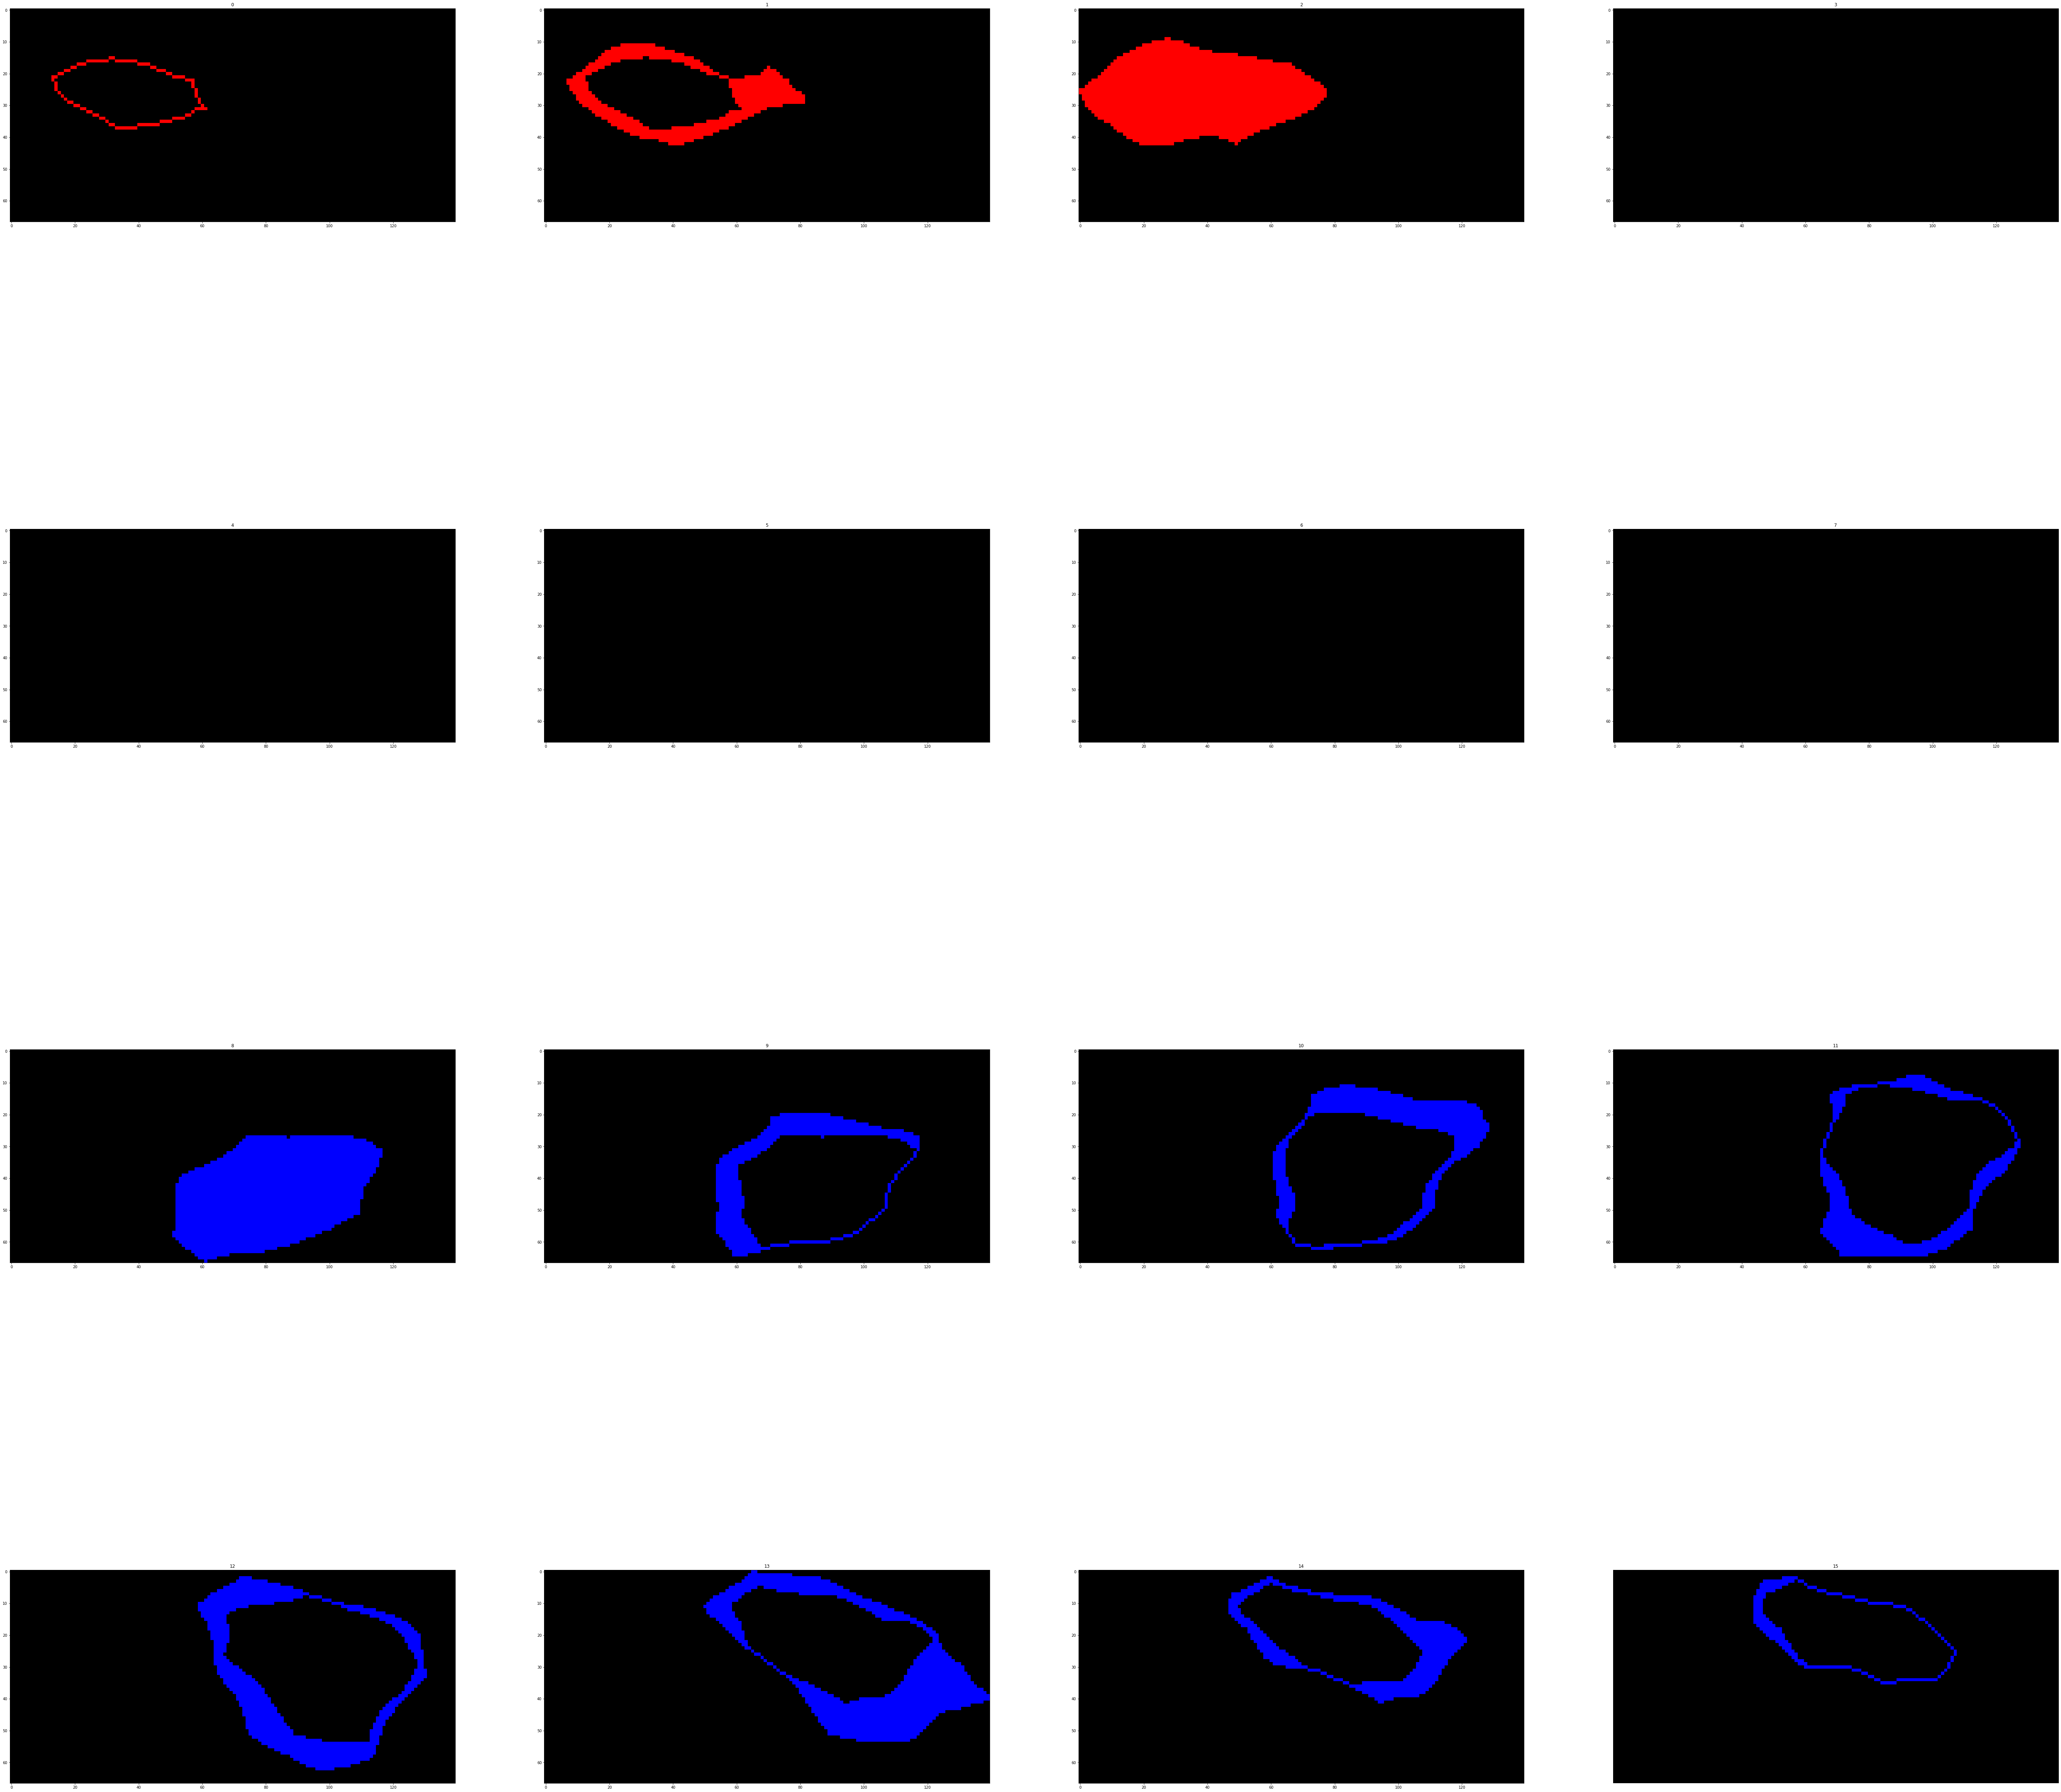

In [398]:
grid_volume(label2rgb(neg_exp,bg_label=0))